# KMeans Clustering with Olivetti Faces

Kevin Nolasco

Cabrini University

MCIS560 - Introduction to Machine Learning

02/20/22

## Introduction

## Get Data

In [1]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()
import numpy as np

Let's get to know the data by exploring the type and viewing some of the methods built in.

In [2]:
type(data)

sklearn.utils.Bunch

In [3]:
help(data)

Help on Bunch in module sklearn.utils object:

class Bunch(builtins.dict)
 |  Bunch(**kwargs)
 |  
 |  Container object exposing keys as attributes.
 |  
 |  Bunch objects are sometimes used as an output for functions and methods.
 |  They extend dictionaries by enabling values to be accessed by key,
 |  `bunch["value_key"]`, or by an attribute, `bunch.value_key`.
 |  
 |  Examples
 |  --------
 |  >>> from sklearn.utils import Bunch
 |  >>> b = Bunch(a=1, b=2)
 |  >>> b['b']
 |  2
 |  >>> b.b
 |  2
 |  >>> b.a = 3
 |  >>> b['a']
 |  3
 |  >>> b.c = 6
 |  >>> b['c']
 |  6
 |  
 |  Method resolution order:
 |      Bunch
 |      builtins.dict
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __dir__(self)
 |      Default dir() implementation.
 |  
 |  __getattr__(self, key)
 |  
 |  __init__(self, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __setattr__(self, key, value)
 |      Implement setattr(self, name, value).
 |  
 |  __se

In [4]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [5]:
data['data'].shape

(400, 4096)

In [6]:
data['target'].shape

(400,)

What are the target variables?

In [7]:
type(data['target'])

numpy.ndarray

In [8]:
np.unique(data['target'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

Ok there are 400 different data points and 40 different target values. My assumption is that each target has 10 data points. Let's see if that is true.

In [9]:
values, counts = np.unique(data['target'], return_counts = True)
for val, count in zip(values, counts):
    print(val, count)

0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10
10 10
11 10
12 10
13 10
14 10
15 10
16 10
17 10
18 10
19 10
20 10
21 10
22 10
23 10
24 10
25 10
26 10
27 10
28 10
29 10
30 10
31 10
32 10
33 10
34 10
35 10
36 10
37 10
38 10
39 10


Looks like the assumption was correct. We need to worry about splitting the data in a strified fashion. Reading the documentation for [train_test_split](#https://stackoverflow.com/questions/29438265/stratified-train-test-split-in-scikit-learn) shows that we can stratify using the stratify attribute.

## Split Data

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], train_size = 0.7, stratify = data['target'])

Let's make sure the class balance is similar accross the two datasets.

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.ticker as mtick


def plot_target_distributions(y_dict):
    ind = 0
    fig, axs = plt.subplots(2,1)
    fig.set_size_inches(10,10)

    for y_key, y_values in y_dict.items():
        y_targets, y_counts = np.unique(y_values, return_counts = True)
        n = y_values.shape[0]
        y_counts = y_counts / n
        if ind == 0:
            color = '#006272'
        else:
            color = '#003366'

        df_ = pd.DataFrame(data = {'targets' : y_targets, 'counts' : y_counts})
        sns.barplot(data = df_, x = 'targets', y = 'counts', ax = axs[ind], color = color)
        axs[ind].get_yaxis().set_visible(False)
        axs[ind].title.set_text('Target Distribution for {}'.format(y_key))

        ind += 1
    plt.tight_layout()
    plt.show()

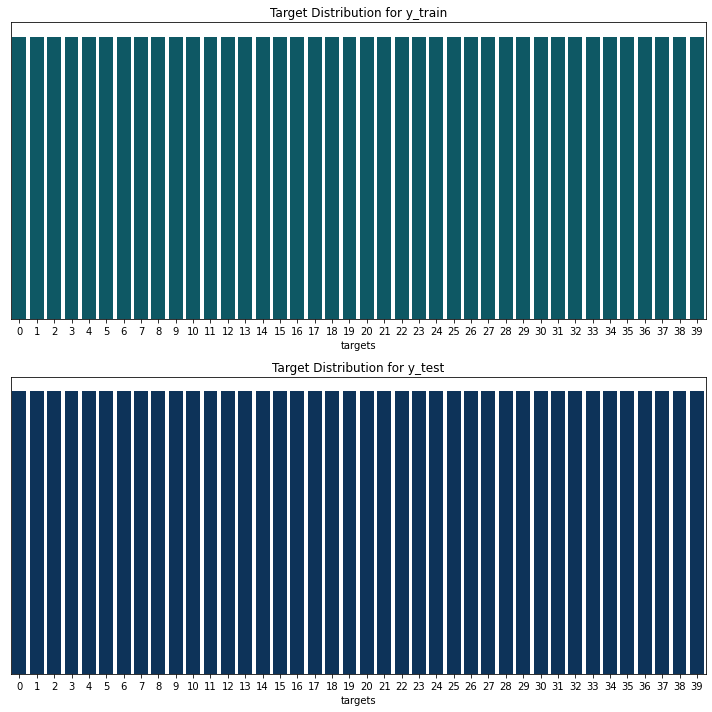

In [12]:
plot_target_distributions({'y_train' : y_train, 'y_test' : y_test})

Above we can see that the each class represents 2.5% of the data in the training and testing set. This confirms that the classes are evenly distributed among the training and testing sets.

## Visualize 25 Faces

From the description of the assignment, we know that the images are flattened but are supposed to be 64 by 64. Let's visualize the first image, then 25 at once.

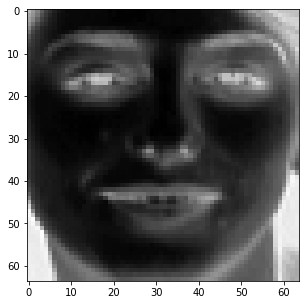

In [13]:
fig, axs = plt.subplots(1,1)
fig.set_size_inches(5,5)

sample = X_train[0].reshape(64, 64)

plt.imshow(sample, cmap = mpl.cm.binary)
plt.show()

Now let's try to make a 5 by 5 grid of the first 25 faces.

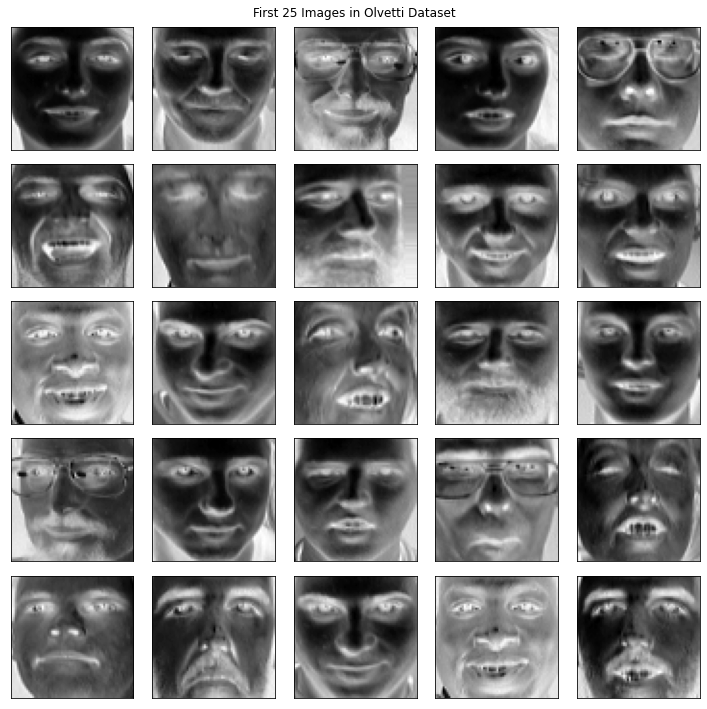

In [14]:
fig, axs = plt.subplots(5,5)

fig.set_size_inches(10,10)

axs = axs.ravel()
for ind in range(25):
    axs[ind].imshow(X_train[ind].reshape(64,64), cmap = mpl.cm.binary)
    axs[ind].set_xticks([])
    axs[ind].set_yticks([])

fig.suptitle('First 25 Images in Olvetti Dataset')
fig.tight_layout()
plt.show()

Looks like some of the faces are the same person from a different angle. My hypothesis is that the clusters will find people that have the similar expressions, or each cluster will be for each person.

## Clustering

We will use k-means clustering in this dataset. To find the optimal number of clusters, we will train a model with 2-40 clusters. I will choose the cluster that has based on the elbow analysis score, and then we can see how it clusters the test set.

In [15]:
from sklearn.cluster import KMeans
from datetime import datetime

N = 60
def train_clusters(data, target, n_clusters = N):

    # set up dict to save cluster
    cluster_dict = {}

    for cluster_ind in range(2, n_clusters + 1):
        cluster_name = 'Cluster_{}'.format(cluster_ind)

        # timer
        start = datetime.now()
        print('================================================\n')
        print('Begining clustering for {} -- {}'.format(cluster_name, start))
        # training
        cluster_dict[cluster_name] = KMeans(n_clusters = cluster_ind, random_state = 8, n_init = 100).fit(data, target)
        end = datetime.now()
        print('{} completed -- {}'.format(cluster_name, end))
        print('Time elapsed : {}\n'.format(end - start))
        print('================================================')

    return cluster_dict

In [16]:
cluster_dict = train_clusters(X_train, y_train)


Begining clustering for Cluster_2 -- 2022-02-17 18:18:42.992547
Cluster_2 completed -- 2022-02-17 18:18:44.568014
Time elapsed : 0:00:01.575467


Begining clustering for Cluster_3 -- 2022-02-17 18:18:44.568014
Cluster_3 completed -- 2022-02-17 18:18:47.007279
Time elapsed : 0:00:02.439265


Begining clustering for Cluster_4 -- 2022-02-17 18:18:47.007279
Cluster_4 completed -- 2022-02-17 18:18:49.767439
Time elapsed : 0:00:02.760160


Begining clustering for Cluster_5 -- 2022-02-17 18:18:49.768440
Cluster_5 completed -- 2022-02-17 18:18:52.919367
Time elapsed : 0:00:03.150927


Begining clustering for Cluster_6 -- 2022-02-17 18:18:52.919367
Cluster_6 completed -- 2022-02-17 18:18:56.461574
Time elapsed : 0:00:03.542207


Begining clustering for Cluster_7 -- 2022-02-17 18:18:56.461574
Cluster_7 completed -- 2022-02-17 18:19:00.418110
Time elapsed : 0:00:03.956536


Begining clustering for Cluster_8 -- 2022-02-17 18:19:00.419110
Cluster_8 completed -- 2022-02-17 18:19:04.857657
Time elap

Find the best cluster using elbow analysis.

In [17]:
def plot_elbow(model_dict, N):
    # make inertia list
    inertias = [model.inertia_ for _ ,model in model_dict.items()]
    cluster_numbers = np.arange(2, N + 1)

    # make plot
    fig, axs = plt.subplots(1,1)
    fig.set_size_inches(50,5)

    g = sns.lineplot(x = cluster_numbers, y = inertias, ax = axs)
    g = sns.scatterplot(x = cluster_numbers, y = inertias, ax = axs)
    axs.set_xticks(cluster_numbers)

    plt.show()

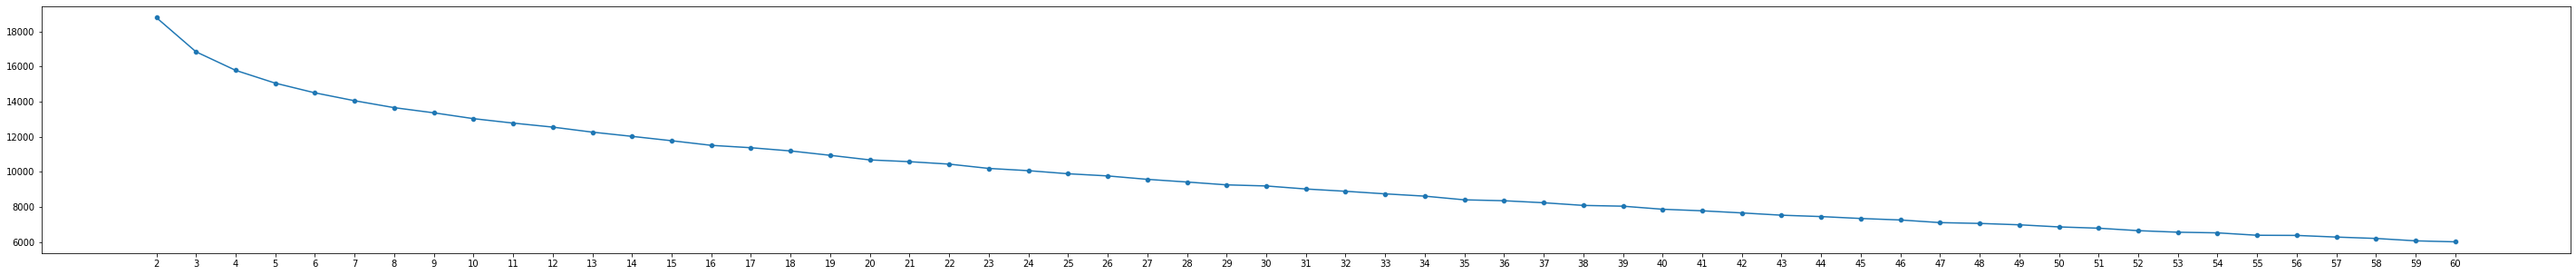

In [18]:
plot_elbow(cluster_dict, N)

The inertia score is difficult to interpret. To find the optimal cluster, we will look at a silhouette score plot.

In [19]:
from sklearn.metrics import silhouette_score

def plot_silhouette(model_dict, N):

    # get list of silhouette scores
    silhouette_scores = [silhouette_score(X_train, model.labels_) for _, model in model_dict.items()]
    cluster_number = np.arange(2,N + 1)

    # make plot
    fig, axs = plt.subplots(1,1)
    fig.set_size_inches(50,5)

    g = sns.lineplot(x = cluster_number, y = silhouette_scores, ax = axs)
    g = sns.scatterplot(x = cluster_number, y = silhouette_scores, ax = axs)
    axs.set_xticks(cluster_number)

    plt.show()

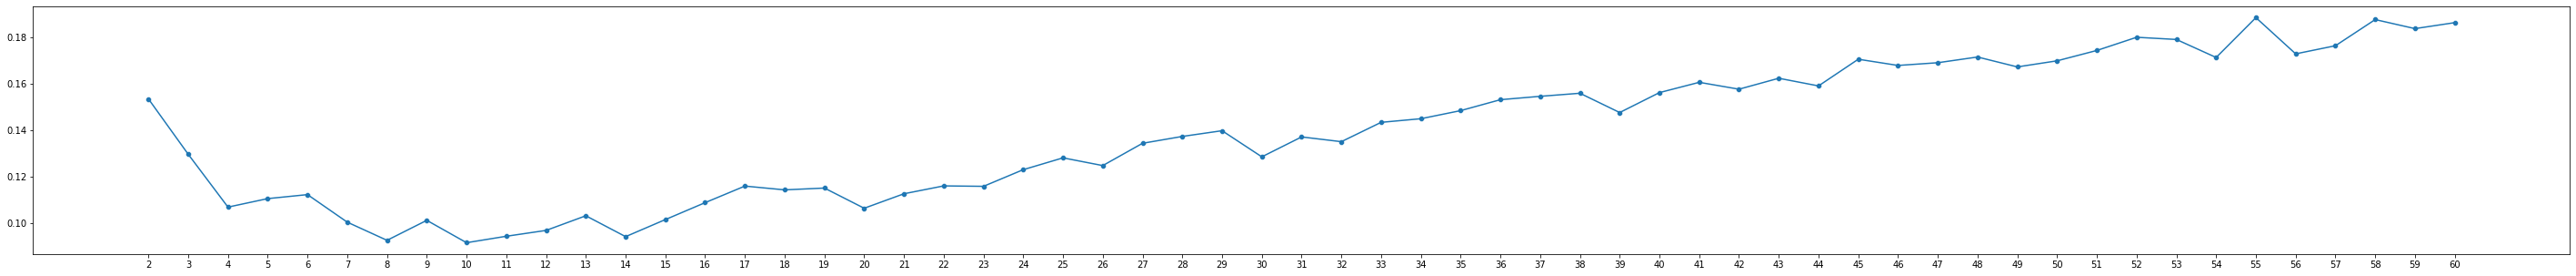

In [20]:
plot_silhouette(cluster_dict, N)

The silhouette analysis is not as insightful as I was hoping. We will pick the model with 40 clusters to begin. Knowing that there are 40 target variables is a good way to know that 40 clusters is a good idea. In other problems, we would have a truly unsupervised learning task and not know how many targets/classes we are looking for. In those instances, we should rely heavily on the elbow and silhouette plot/diagram.

In [21]:
my_model = cluster_dict['Cluster_40']

Let's see cluster which of the training faces are grouped together for this model. To simplify, let's just look at label 2 (arbitrarily chosen.)

In [90]:
def plot_clustered_label(label, model, X):
    label_preds = model.predict(X)

    label_index = np.where(label_preds == label)
    X_example = X[label_index]
    n = np.array(label_index).shape[1]

    if n == 1:
        plt.imshow(X_example.reshape(64,64), cmap = mpl.cm.binary)
    else:
        fig, axs = plt.subplots(1, n)
        fig.set_size_inches(10*n, 10)

        for ind in range(n):
            axs[ind].imshow(X_example[ind].reshape(64,64), cmap = mpl.cm.binary)
        plt.show()

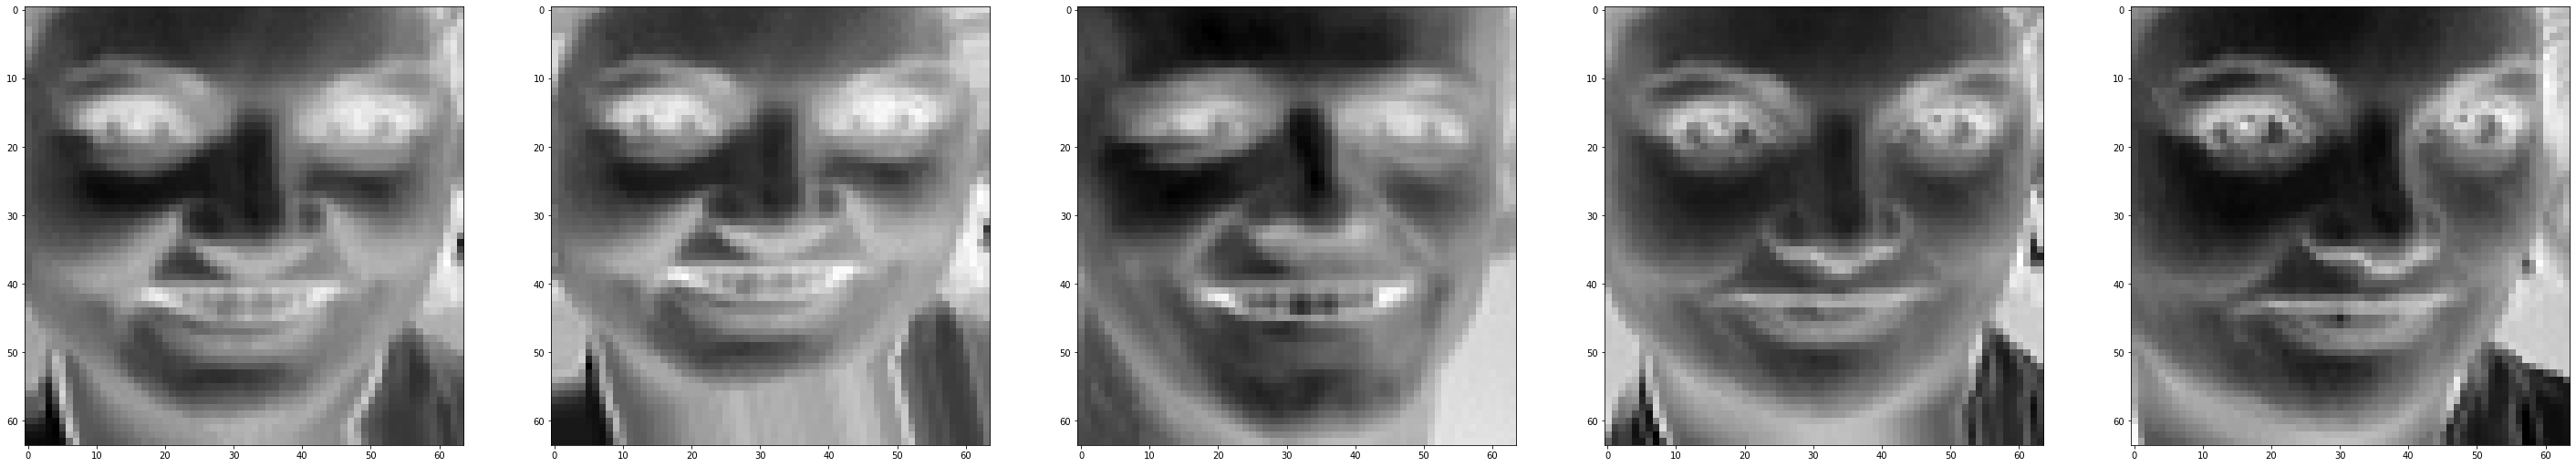

In [91]:
plot_clustered_label(label = 2, model = my_model, X = X_train)

Looks like the faces above are of the same person, except for the center image which was probably mis-classified. Let's look at this label but for the test set.

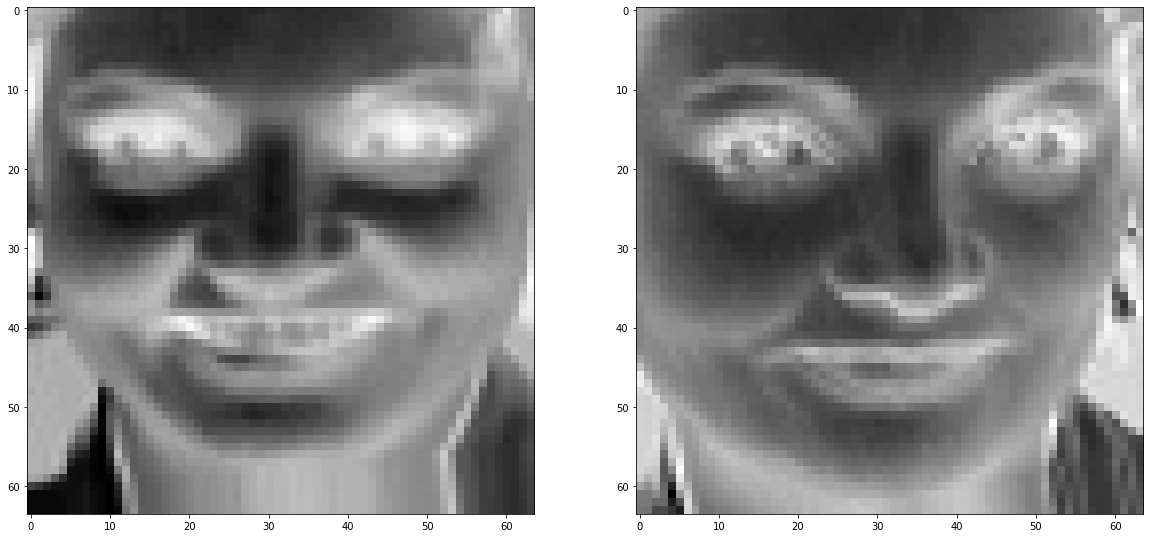

In [94]:
plot_clustered_label(label = 2, model = my_model, X = X_test)

Cool! The model correctly classified the person in the training and testing sets. Let's see how it did with another label.

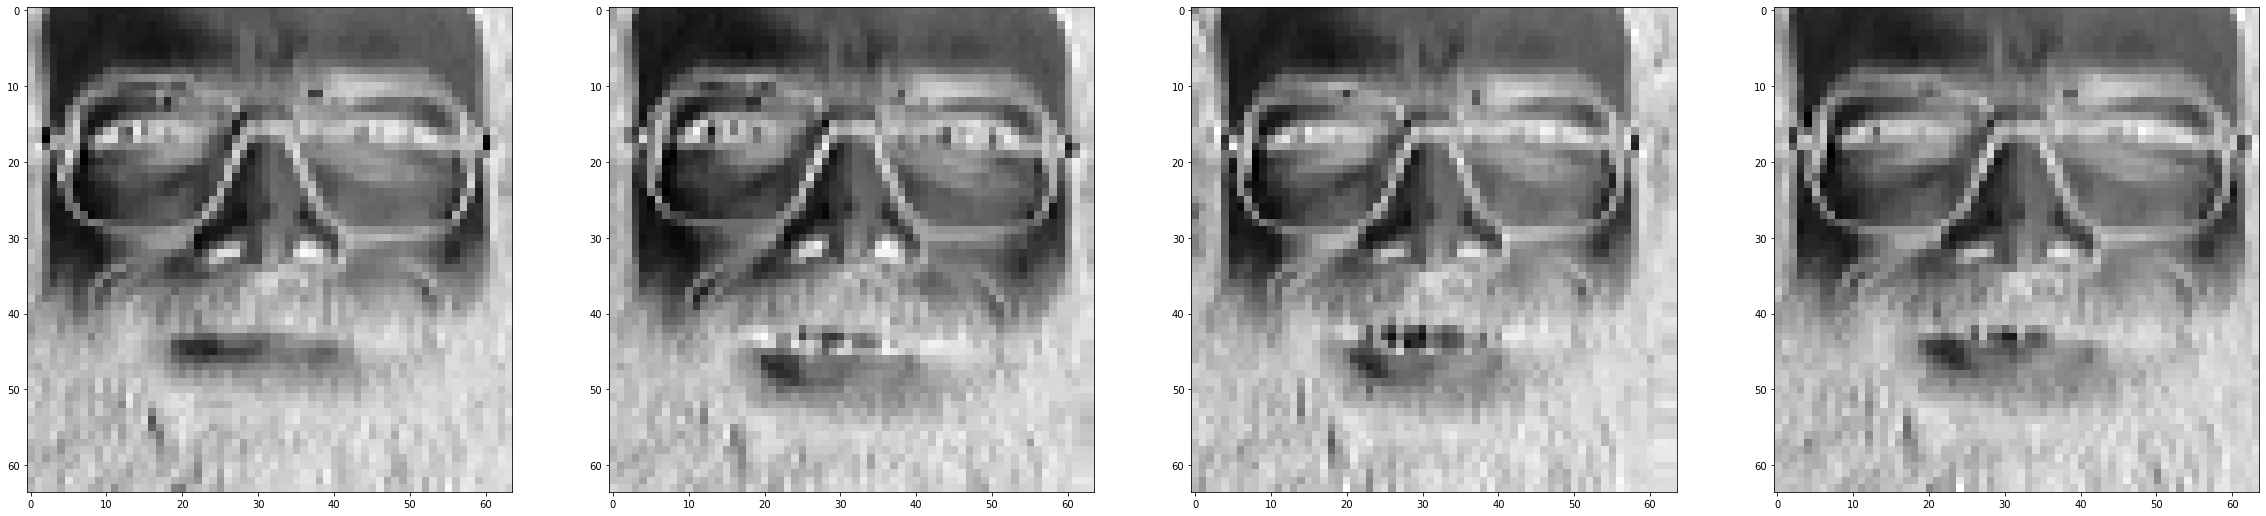

In [86]:
plot_clustered_label(label = 8, model = my_model, X = X_train)

For label 8, we see that it's the same person that was grouped into a single cluster. Let's see how it performs on the test set.

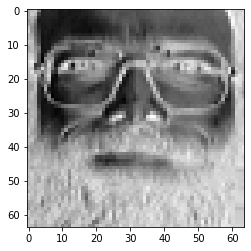

In [92]:
plot_clustered_label(label = 8, model = my_model, X = X_test)